In [1]:
from methods.llava_utils import load_llava_state
from methods.blip_utils import load_blip_state
from tqdm import tqdm
import os
import pickle
from methods.algorithms import get_phrase_embedding, generate_mass_edit_hook, remove_all_hooks
from methods.utils import coco_img_id_to_name, display_image
import torch
import random

torch.set_grad_enabled(False)

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
os.environ['VL_ROOT_DIR'] = '/home/nickj/vl' # Set this environment variable to the root directory (ex. an absolute path) of this repository

os.chdir(os.environ["VL_ROOT_DIR"])

In [12]:
model_type = "blip7b"
lT = 1
lI = 2
alpha = 1.5
device = "cuda:0"
prompt = "Write a detailed description."

In [4]:
if model_type == "llava7b":
  # Load the LlaVA model
  loaded_state = load_llava_state(device = device)
elif model_type == "blip7b":
  loaded_state = load_blip_state(device = device)
else:
  raise Exception(f"model type {model_type} not supported")

vocabulary, vocab_embeddings, execute_model, register_hook, tokenizer, hidden_layer_embedding = loaded_state["vocabulary"], loaded_state["vocab_embeddings"], loaded_state["execute_model"], loaded_state["register_hook"], loaded_state["tokenizer"], loaded_state["hidden_layer_embedding"]

id_to_token = dict()
for word in vocabulary:
  id_to_token[vocabulary[word]] = word

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertLMHeadModel were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['bert.encoder.layer.0.crossattention.output.LayerNorm.bias', 'bert.encoder.layer.0.crossattention.output.LayerNorm.weight', 'bert.encoder.layer.0.crossattention.output.dense.bias', 'bert.encoder.layer.0.crossattention.output.dense.weight', 'bert.encoder.layer.0.crossattention.self.key.bias', 'bert.encoder.layer.0.crossattention.self.key.weight', 'bert.encoder.layer.0.crossattention.self.query.bias', 'bert.encoder.layer.0.crossattention.self.query.weight', 'bert.encoder.layer.0.crossattention.self.value.bias', 'bert.encoder.layer.0.crossattention.self.value.w

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


In [5]:
coco_img = 540159
image_path = os.path.join('./images', coco_img_id_to_name(coco_img) + ".jpg")

In [6]:
evaluator = pickle.load(open('./metric/chair.pkl', "rb"))

In [7]:
# Get baseline caption
baseline_caption = execute_model(image_path, text_prompt = prompt)
baseline_evals = evaluator.compute_hallucinations(coco_img, baseline_caption)

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `-1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


['The image depicts a cozy living room with a white couch situated in the center of the space. The couch is adorned with colorful crocheted blankets, adding a touch of warmth and personality to the room. A wooden coffee table is placed in front of the couch, providing a convenient spot for drinks, books, and other items. In addition to the couch and coffee table, there are several other pieces of furniture in the room. A chair can be seen on the left side of the image, while another chair is located on the right side. Both chairs are positioned close to the couch, suggesting that they might be used for additional seating during social gatherings. There is also a book placed on the coffee table, adding to the relaxing atmosphere of the room.']


/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


In [8]:
# Select a target object to erase and extract a text embedding for the object
# You don't just have to select hallucinations.

text_embeddings = []
for caption_word, coco_class in set(baseline_evals["mscoco_hallucinated_words"]):
  text_embeddings.append(hidden_layer_embedding(caption_word, layer = lT))

In [13]:
# Hook into the model's intermediate activations to linearly edit them
remove_all_hooks(loaded_state["model"].model)
if model_type == "llava7b":
  edit_embeddings_hook = generate_mass_edit_hook(text_embeddings, start_edit_index=35, end_edit_index=611, layer=lI, weight = alpha, minimum_size=576)
else:
  edit_embeddings_hook = generate_mass_edit_hook(text_embeddings, start_edit_index=0, end_edit_index=32, layer=lI, weight = alpha, minimum_size=32)
hook = register_hook(edit_embeddings_hook, lI)

# Remember to remove the hook if you want to try another layer!
# hook.remove()

In [14]:
new_caption = execute_model(image_path, text_prompt = prompt)

# Compute the hallucinations
new_chair_eval = evaluator.compute_hallucinations(coco_img, new_caption)

/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `-1` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


Editing layer 2
['The image shows a living room with a sofa and a table in the middle. The sofa is placed on the left side of the room, and the table is in the middle of the room. There is a TV on the right side of the room, and a bookshelf on the left side of the room. Two people are sitting on the sofa, one on the left side and one on the right side. There is a lot of activity happening in the room, with people moving around and interacting with each other.']
Editing layer 2


/home/nickj/miniconda3/envs/vl-copy/lib/python3.9/site-packages/transformers/generation/configuration_utils.py:397: UserWarning: `do_sample` is set to `False`. However, `top_p` is set to `0.9` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `top_p`.
  warnings.warn(


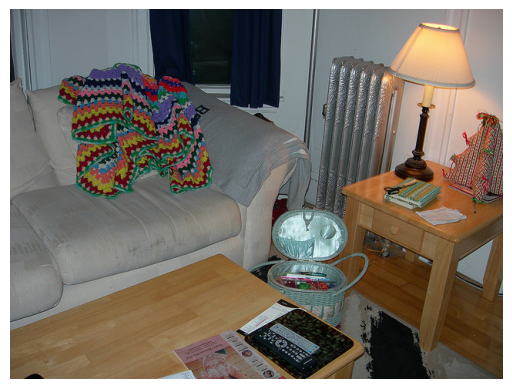

==== Baseline ====
<s> The image depicts a cozy living room with a white couch situated in the center of the space. The couch is adorned with a crocheted blanket, which adds a warm and inviting touch to the room.  There are several items placed around the couch, including a book on the left side, a cup on the right side, and a remote control on the back of the couch. A lamp is positioned above the couch, providing additional lighting for the room.  In addition to the couch, there is a wooden coffee table located in the middle of the room. The table has a bowl placed on top of it, likely used for storing small items or as a decorative piece. A chair can be seen on the left side of the room, offering additional seating options. Overall, the living room appears to be well-appointed and inviting, perfect for relaxation and spending time with loved ones.
{'mscoco_hallucinated_words': [('cup', 'cup'), ('bowl', 'bowl'), ('chair', 'chair')], 'mscoco_gt_words': ['scissors', 'book', 'couch', 're

In [15]:
display_image(image_path)
print("==== Baseline ====")
print(baseline_caption)
print(baseline_evals)
print("==== Edited ====")
print(new_caption)
print(new_chair_eval)